# Time Series Analysis: ARIMA Model (Autoregressive Integrated Moving Average)

## Part I: Research Question

### A1. Research Question

Can a model be generated to forecast the company's future revenue?

### A2. Objectives/Goals of the Data Analysis given the scenario presented

The goal of this analysis is to generate an autoregressive integrated moving average (ARIMA) model to forecast the company's future revenue. The company's most recent 2 years of revenue data will be used to build an ARIMA model for forecasting.

## Part II: Method Justification

### B. Assumptions of a Time Series Model, including Stationarity and Autocorrelated Data

Two of the assumptions of time series analysis using ARIMA is that the data is stationary and without autocorrelation. A dataset is stationary if the joint distributions of the data or the mean, variance, and autocorrelations of the data do not "depend on time" (Datacamp, n.d.). It cannot have a trend within the data, and the variance and autocorrelation must be constant. Autocorrelation refers to when future values within a time series "linearly depend on past values" (Pierre, 2022).
The Augmented Dickey-Fuller (ADF) Test will be used to assess if the time series is stationary. When utilizing the ADF test, the null hypothesis is that the dataset is non-stationary (Tate, 2023). Autocorrelation function plots will be used to visualize the autocorrelation of the time series. It will show the correlation between the series and its lagged values at different lag intervals. In this situation the lag intervals as seen in the analysis below are 1 day.

## Part III: Data Preparation

### C1. Provide a Line Graph Visualizing the Realization of the Time Series

In [1]:
from platform import python_version
("Python version used during this analysis:", python_version())

('Python version used during this analysis:', '3.8.5')

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pylab
import statistics
import seaborn as sns

from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

import sklearn
from sklearn import preprocessing
from sklearn import datasets
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from scipy import signal
from datetime import datetime
from tqdm import tqdm
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

print("Done.")

Done.


In [3]:
churn_df=pd.read_csv('Desktop/WGU/D213/teleco.csv')
print("Imported.")

Imported.


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 60)

print("Display size adjusted.")

Display size adjusted.


In [5]:
churn_df.shape

(731, 2)

In [6]:
churn_df.head(10)

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
5,6,0.107654
6,7,0.493901
7,8,0.376698
8,9,0.304075
9,10,0.591748


In [7]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


**Assessing for missing values**

In [8]:
churn_df.isnull().sum()

Day        0
Revenue    0
dtype: int64

No nulls present.

**Viewing summary statistics**

In [9]:
churn_df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


### C2. Describe the Time Step Formatting of the Realization, including ANY gaps in Measurement and the Length of the Sequence

**Converting to Date with DateTime**

In [10]:
#from datetime import datetime
#Converting the 'Day' variable to a date
churn_df['Day']=(pd.date_range(start=datetime(2022, 1, 1), periods=churn_df.shape[0], freq='24H'))
#Setting 'Day' as the index
churn_df.set_index('Day', inplace=True)

In [11]:
churn_df.head()

,Revenue
Day,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554


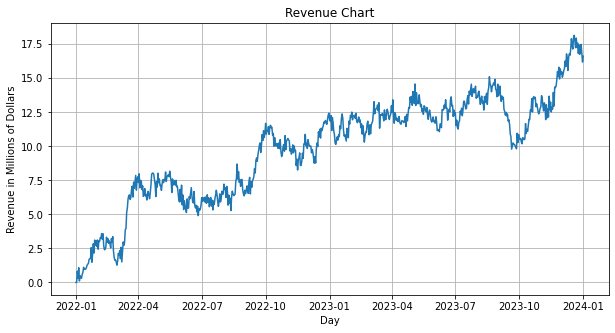

In [12]:
plt.figure(figsize=(10,5))
plt.plot(churn_df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in Millions of Dollars')
plt.grid(True)
plt.show()

### C3. Evaluate the Stationarity of the Time Series
Code Source: (Tate, 2023)

In [13]:
#from statsmodels.tsa.stattools import adfuller
adf_result=adfuller(churn_df['Revenue'])
print("Test statistic: ", adf_result[0])
print("p-vaue: ", adf_result[1])
print("Critical values: ", adf_result[4])

Test statistic:  -1.9246121573101798
p-vaue:  0.32057281507939817
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


The test statistic is not less than the critical values, so at first glance, we are inclined to fail to reject the null hypothesis, but we will assess the p-value related to the test statistic now to calculate the strength of that evidence (Tate, 2023).

In [14]:
if adf_result[1]<=0.05: 
    print("Reject null hypothesis, the time series is stationary (the alternative hypothesis is correct).")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary (the null hypothesis is correct)")

Fail to reject null hypothesis, the time series is non-stationary (the null hypothesis is correct)


In [15]:
#viewing df before making the time series stationary
churn_df.head()

,Revenue
Day,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554


In [16]:
#Making the time series stationary
churn_df_stationary = churn_df.diff().dropna()
churn_df_stationary.head()

,Revenue
Day,
2022-01-02,0.000793
2022-01-03,0.824749
2022-01-04,-0.505210
2022-01-05,0.762222
2022-01-06,-0.974900


In [17]:
#reassessing for stationarity
adf_result=adfuller(churn_df_stationary['Revenue'])
print("Test statistic: ", adf_result[0])
print("p-vaue: ", adf_result[1])
print("Critical values: ", adf_result[4])

Test statistic:  -44.874527193875984
p-vaue:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


The test statistic is less than the critical values, so we fail to reject the null hypothesis, but we will again assess the p-value related to the test statistic now to calculate the strength of that evidence (Tate, 2023).

In [18]:
if adf_result[1]<=0.05: 
    print("Reject null hypothesis, the time series is stationary (the alternative hypothesis is correct).")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary (the null hypothesis is correct)")

Reject null hypothesis, the time series is stationary (the alternative hypothesis is correct).


In [19]:
train=churn_df.iloc[:-30]
test=churn_df.iloc[-30:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (701, 1)
Test shape: (30, 1)


In [20]:
test #viewing the test data

,Revenue
Day,
2023-12-03,15.269829
2023-12-04,15.563935
2023-12-05,15.709684
2023-12-06,16.270576
2023-12-07,15.864648
2023-12-08,16.791981
2023-12-09,16.446698
2023-12-10,15.576833
2023-12-11,16.517375


### C4. Explain the Steps You Used to Prepare the Data for Analysis, Including the Training and Test Set Split

The dataset was imported from the CSV file. The data shape was assessed using the .shape function. The data was previewed using the .head function. The column names and datatypes were reviewed using the .info function. It was assessed for null values, but none were present. The .describe function was used to view summary statistics. The dataset has 731 rows and the 'Day' variable has a minimum of 1 and a maximum of 731. The 'Day' variable was converted to a date using the DateTime package. The revenue was plotted using MatPlotLib's PyPlot so it could be visualized. 
The Augmented Dickey-Fuller (ADF) Test was used to assess if the time series was stationary. When utilizing the ADF test, the null hypothesis is that the dataset it non-stationary (Tate, 2023).
As seen above, the revenue data was found to be not stationary, therefore the data was then differenced and the ADF test was repeated. The results of the repeated ADF test showed that the data was stationary.
The original non-stationary data was split into testing and training sets. 

### C5. Copy of Prepared Data Set

In [21]:
churn_df_stationary.to_csv('churn_prepared_time_series.csv')

## Part IV: Model Identification and Analysis

### D1. Report the Annotated Findings with Visualizations of your Data Analysis, including: 

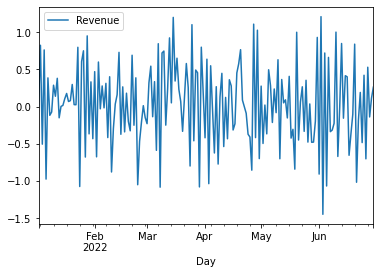

<Figure size 864x288 with 0 Axes>

In [22]:
churn_df_stationary.loc[:'2022-6-30'].plot()
plt.figure(figsize=(12,4))
plt.show()

#### the autocorrelation function

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

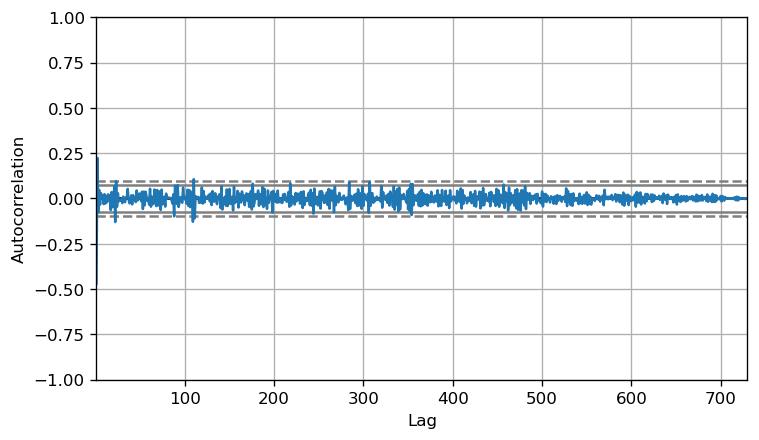

In [23]:
#from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':120})
autocorrelation_plot(churn_df_stationary.Revenue.tolist())

(-0.5, 0.5)

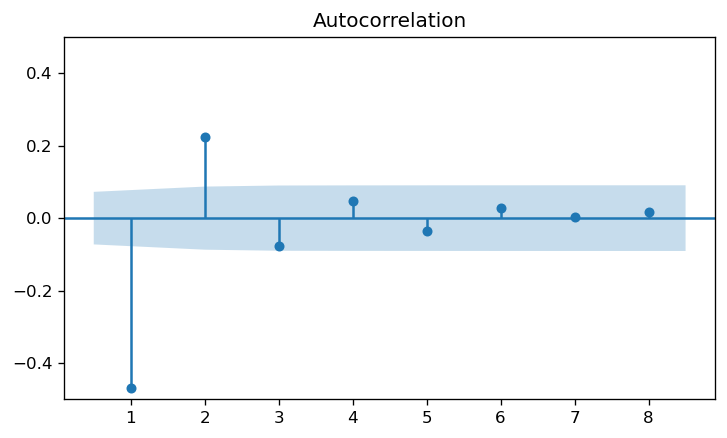

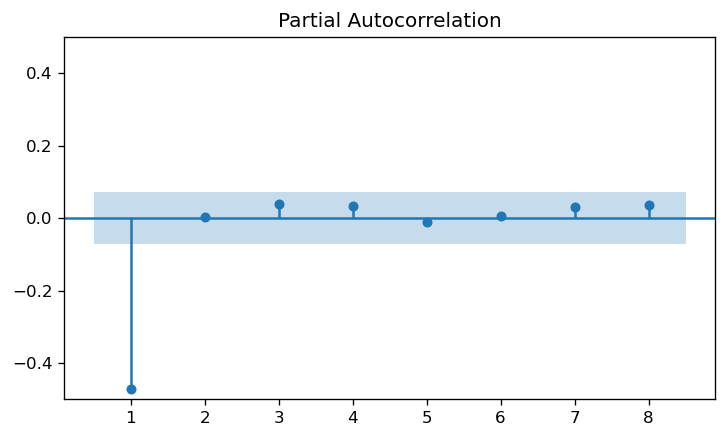

In [24]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF to 8 lags since zero always = 1
plot_acf(churn_df_stationary, lags=8, zero=False)
plt.ylim(-0.5, 0.5) # Zoom in on y axis

# Plot PACF to 8 lags since zero always = 1
plot_pacf(churn_df_stationary, lags=8, zero=False)
plt.ylim(-0.5, 0.5)# Zoom in on y axis

As seen in the autocorrelation and partial autocorrelation plots above, the values plotted at 1 are the zero values for these plots, so those initial points can be disregarded. Upon visual inspection of the above plots, at lags 2-8 you can see that the values are all very close to zero, with both some negative values and some positive values. While positive lags would indicate a positive correlation between the series and its lagged values, and a negative value would indicate a negative correlation, the magnitude of these values is very weak. This suggests a very weak correlation. 

#### the spectral density

First, plotting the non-stationary data

(array([6.97387711e+03, 3.91439441e+03, 5.47611144e+01, 1.10791953e+01,
        4.25439684e+00, 8.90767103e+00, 9.32436541e+00, 5.07699490e+00,
        4.50820186e+00, 1.97142105e+00, 3.17930644e+00, 2.05465010e+00,
        1.27856111e-01, 9.12357670e-01, 1.58928494e+00, 1.82600308e+00,
        1.37345831e+00, 1.08602805e+00, 3.71664573e-01, 4.01447712e-01,
        6.67019362e-01, 4.28134847e-01, 1.08303874e+00, 5.05461139e-01,
        1.49612021e-01, 2.01156666e-01, 2.01929017e-01, 3.62482513e-02,
        4.74386760e-01, 5.46619399e-01, 2.44460915e-01, 4.75225583e-01,
        2.85007556e-01, 7.59631735e-02, 2.43183009e-01, 7.19503505e-02,
        3.60475608e-01, 2.18971480e-01, 1.23421972e-01, 1.69234109e-01,
        1.69371921e-01, 1.14748035e-01, 2.14144408e-01, 2.82736486e-01,
        3.17059554e-02, 1.62458482e-02, 3.98324693e-02, 6.38895068e-02,
        4.57061837e-02, 6.54718394e-02, 1.72598760e-01, 1.32802101e-01,
        6.74716970e-02, 1.61089989e-02, 1.42266347e-01, 1.236409

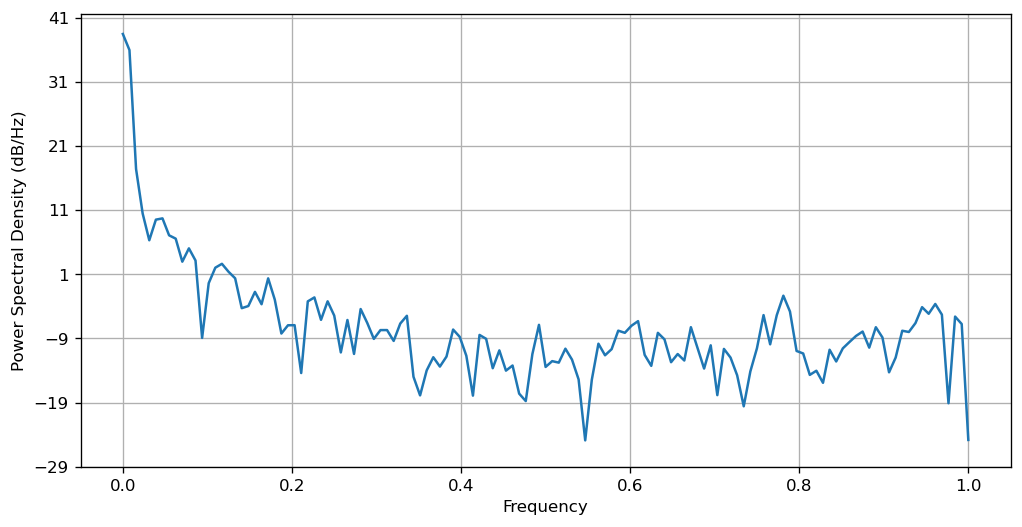

In [25]:
plt.figure(figsize=(10,5), linewidth=3)
plt.psd(churn_df['Revenue'])

Second, plotting the stationary data

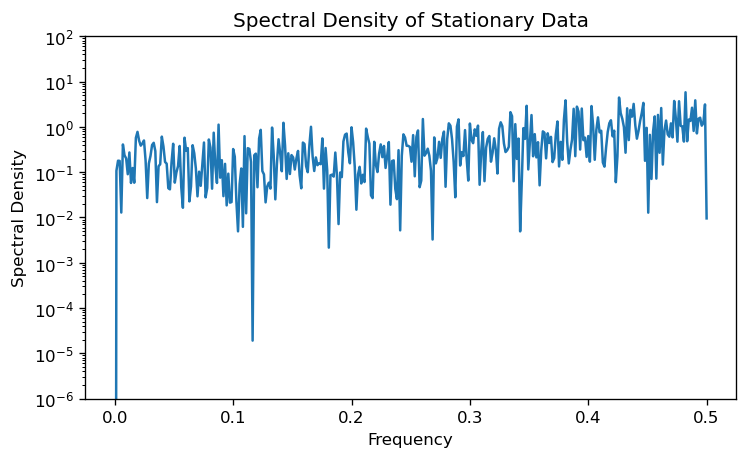

In [26]:
#from scipy import signal
f, Pxx_den = signal.periodogram(churn_df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density of Stationary Data')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

Upon visual inspection of the above graphs, there is no visible seasonality, that is there are no discernable patterns within the data. The centerline is around zero, so there is no seasonality visible.

#### the decomposed time series

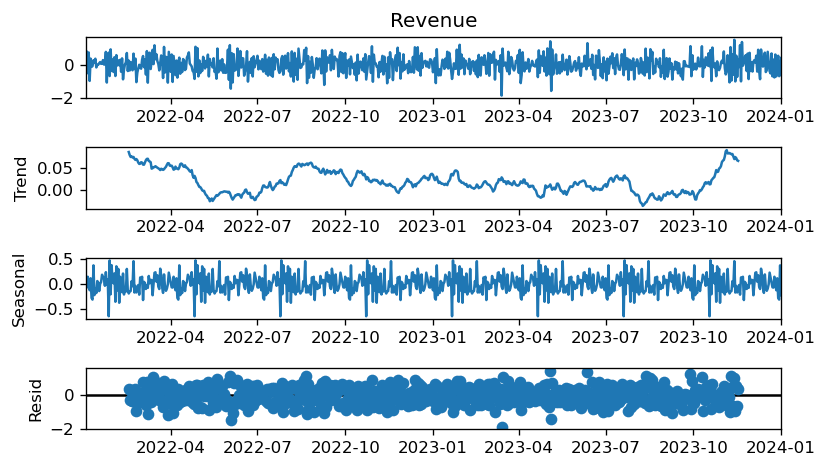

<Figure size 1440x480 with 0 Axes>

In [27]:
#from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(churn_df_stationary['Revenue'], period=90)

decomp.plot()
plt.figure(figsize=(12,4))
plt.show()

This is the decomposition graph of the four graphs which have been individually generated. The bottom three are labeled (Residual, Seasonal, Trend). The top graph is the original revenue.

#### the presence of lack of a seasonal component

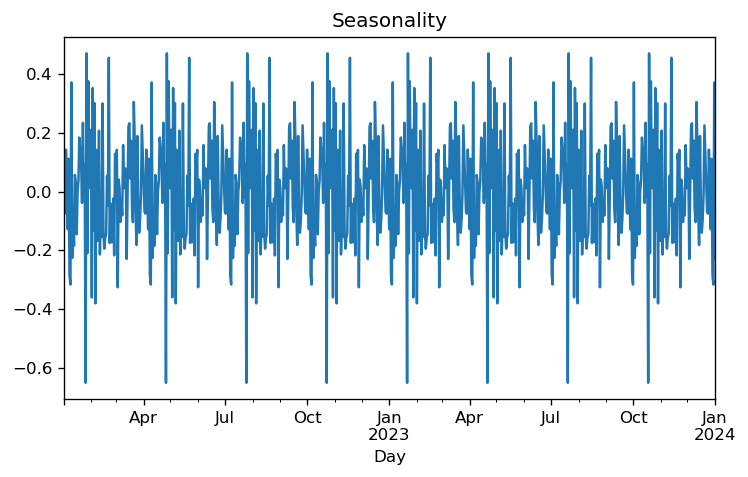

<Figure size 1440x480 with 0 Axes>

In [28]:
plt.title('Seasonality')
decomp.seasonal.plot()
plt.figure(figsize=(12, 4))
plt.show()

Viewing the graph generated from the decomposition analysis, there is no visible seasonality in the data.

#### trends

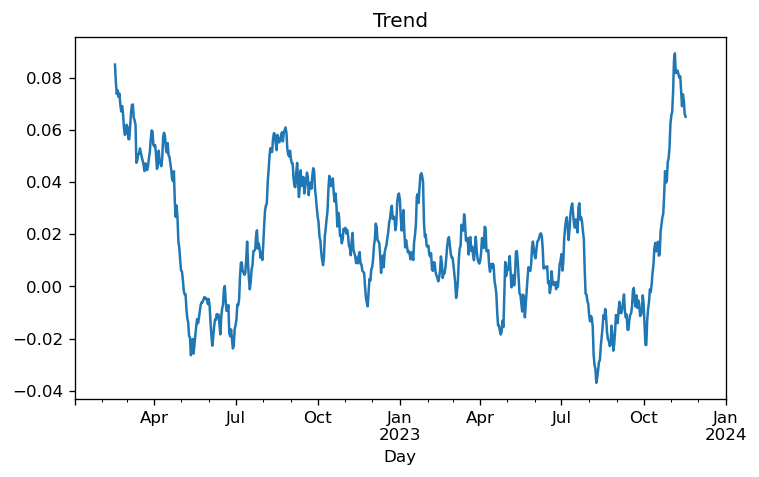

<Figure size 1440x480 with 0 Axes>

In [29]:
plt.title('Trend')
decomp.trend.plot()
plt.figure(figsize=(12,4))
plt.show()

Viewing the above graph generated by the decomposition analysis, there is no visible trend in the data.

#### confirmation of the lack of trends in the residuals of the decomposed series

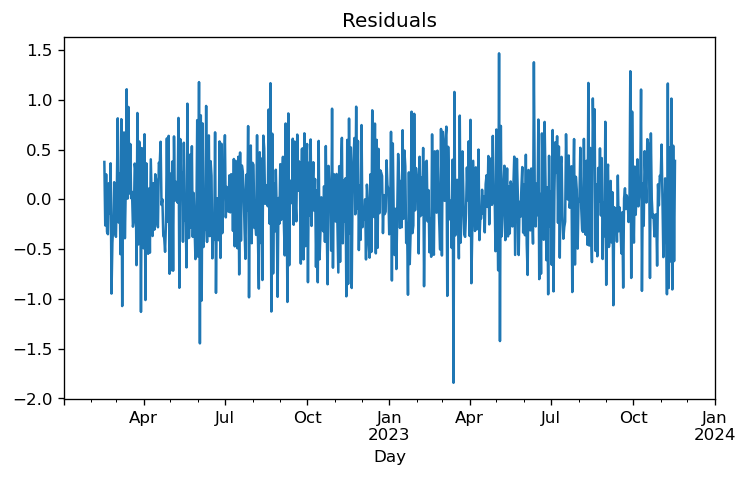

<Figure size 1440x480 with 0 Axes>

In [30]:
plt.title('Residuals')
decomp.resid.plot()
plt.figure(figsize=(12,4))
plt.show()

Upon visual inspection, the residuals of the decomposition do not appear to have any apparent trend visualized in the above graph

### D2. Autoregressive Integrated Moving Average (ARIMA) Model

In [31]:
#from pmdarima import auto_arima
stepwise_fit=auto_arima(churn_df['Revenue'], trace=True, supress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.733 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Fri, 16 Feb 2024   AIC                            983.122
Time:                        01:46:35   BIC                            996.901
Sample:                    01-01-2022   HQIC                           988.438
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
#from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1, 1, 0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  701
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -466.837
Date:                Fri, 16 Feb 2024   AIC                            937.673
Time:                        01:46:35   BIC                            946.776
Sample:                    01-01-2022   HQIC                           941.192
                         - 12-02-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4712      0.033    -14.142      0.000      -0.537      -0.406
sigma2         0.2221      0.013     17.624      0.000       0.197       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.85   Prob(JB):                         0.49
Heteroskedasticity (H):               0.96   Skew:                            -0.00
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
#start = len(train)
start=701
#end = len(train) + len(test) - 1
end=730
#Predict using the ARIMA model
pred = model.predict(start=start, end=end, type='levels')
print(pred)
pred.index=churn_df.index[start:end+1]

2023-12-03    15.268097
2023-12-04    15.178486
2023-12-05    15.220713
2023-12-06    15.200814
2023-12-07    15.210191
2023-12-08    15.205772
2023-12-09    15.207855
2023-12-10    15.206873
2023-12-11    15.207336
2023-12-12    15.207118
2023-12-13    15.207221
2023-12-14    15.207172
2023-12-15    15.207195
2023-12-16    15.207184
2023-12-17    15.207189
2023-12-18    15.207187
2023-12-19    15.207188
2023-12-20    15.207187
2023-12-21    15.207188
2023-12-22    15.207188
2023-12-23    15.207188
2023-12-24    15.207188
2023-12-25    15.207188
2023-12-26    15.207188
2023-12-27    15.207188
2023-12-28    15.207188
2023-12-29    15.207188
2023-12-30    15.207188
2023-12-31    15.207188
2024-01-01    15.207188
Freq: D, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Day'>

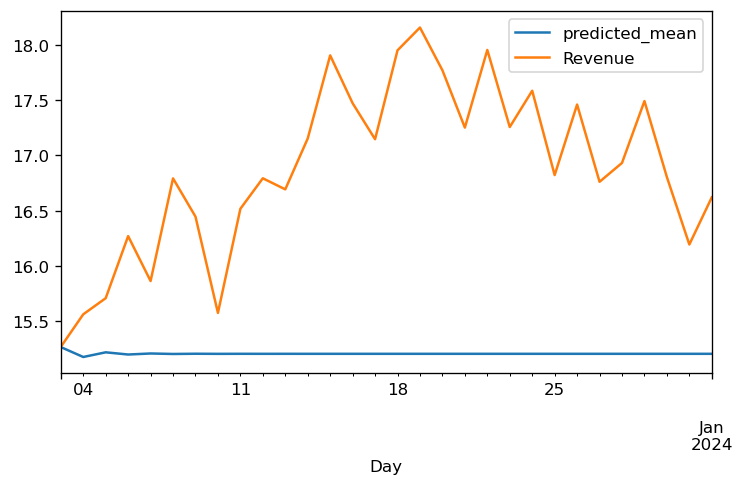

In [34]:
pred.plot(legend=True)
test['Revenue'].plot(legend=True)

**Root Mean Sqared Error (RMSE)**

In [35]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt
rmse=(sqrt(mean_squared_error(pred,test['Revenue'])))
print("The root mean squared error of this model is:")
rmse

The root mean squared error of this model is:


1.8316544159889558

In [36]:
model2=ARIMA(churn_df['Revenue'], order=(1,1,0))
model2=model2.fit()
churn_df.tail()

,Revenue
Day,
2023-12-28,16.931559
2023-12-29,17.490666
2023-12-30,16.803638
2023-12-31,16.194814
2024-01-01,16.620798


**The ARIMA model was generated with a p,d,q of (1,1,0). The model has a RMSE of 1.8316544159889558**

### D3. Perform a Forecast using the derived ARIMA model identified in D2

In [37]:
index_future_dates=pd.date_range(start='2024-01-01', end='2024-01-31')
print(index_future_dates)

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', freq='D')


In [38]:
start=len(churn_df)
start

731

In [39]:
end=len(churn_df)+30
end

761

In [40]:
pred=model2.predict(start=731, end=761, type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
pred

2024-01-01    16.422010
2024-01-02    16.514776
2024-01-03    16.471486
2024-01-04    16.491688
2024-01-05    16.482261
2024-01-06    16.486660
2024-01-07    16.484607
2024-01-08    16.485565
2024-01-09    16.485118
2024-01-10    16.485326
2024-01-11    16.485229
2024-01-12    16.485275
2024-01-13    16.485253
2024-01-14    16.485263
2024-01-15    16.485259
2024-01-16    16.485261
2024-01-17    16.485260
2024-01-18    16.485260
2024-01-19    16.485260
2024-01-20    16.485260
2024-01-21    16.485260
2024-01-22    16.485260
2024-01-23    16.485260
2024-01-24    16.485260
2024-01-25    16.485260
2024-01-26    16.485260
2024-01-27    16.485260
2024-01-28    16.485260
2024-01-29    16.485260
2024-01-30    16.485260
2024-01-31    16.485260
Freq: D, Name: ARIMA Predictions, dtype: float64

<AxesSubplot:>

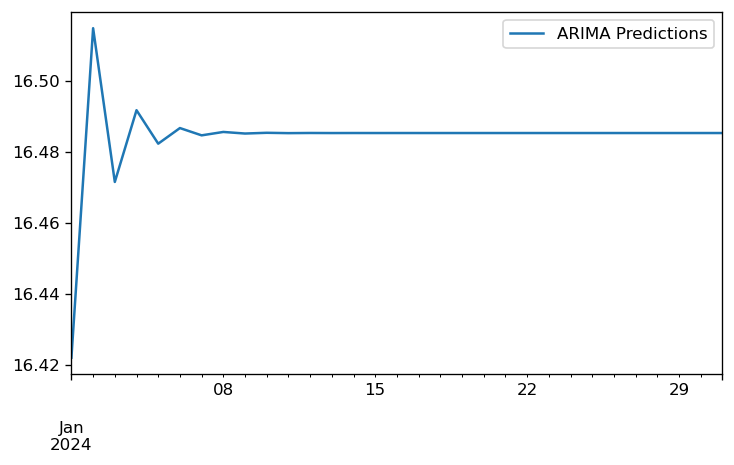

In [41]:
pred.plot(legend=True)

### D4. Provide the Output and Calculations of the Analysis You Performed

*See above*

### D5. Provide the Code Used to Support the Implementation of the Time Series Model

*See above*

## Part V: Data Summary and Implications

### E1. Discuss the Results of Your Data Analysis, Including the Following Points:
the selection of an ARIMA model, the prediction interval of the forecast, a justification of the forecast length,  the model evaluation procedure and error metric

The final model was created based upon the results of the auto-ARIMA with values for p,d,q of (1,1,0). The prediction interval of the forecast was 30 days. The revenue data provided was only 2 years worth of data, as this is a new company. As the company accrues more data with time, a new model can be created to forecast further into the future. The root mean squared error (RMSE) of the final model was 1.8316544159889558.   

### E2. Annotated Visualization of the Forecast of the Final Model Compared to the Test Set

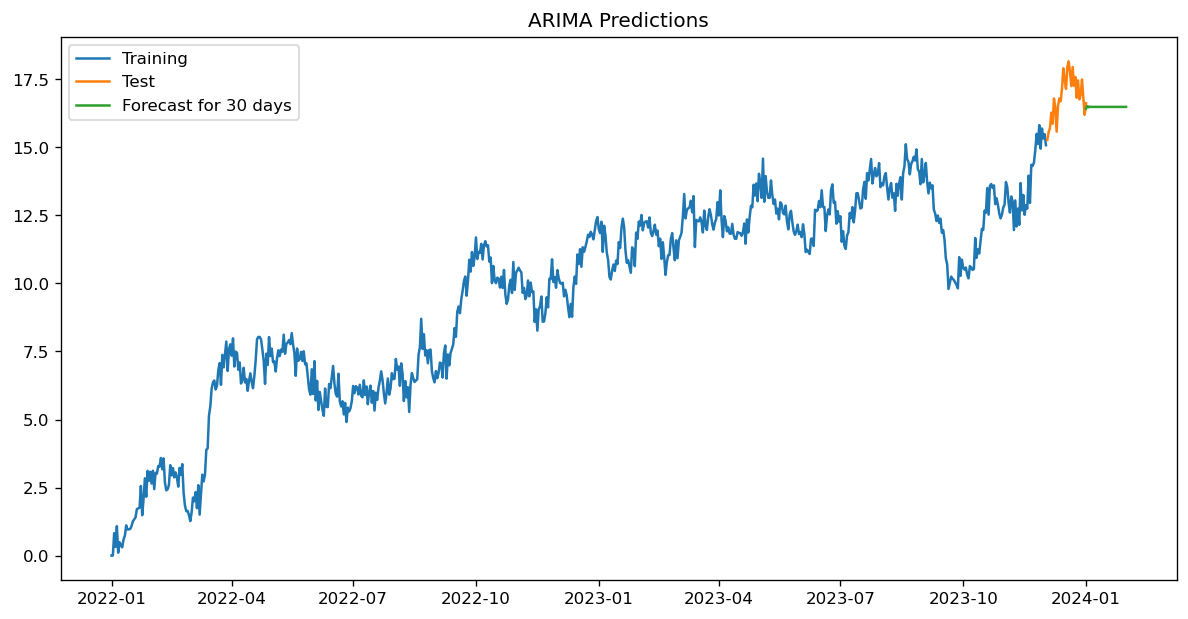

In [43]:
plt.figure(figsize=(12,6))
plt.plot(train['Revenue'], label='Training')
plt.plot(test['Revenue'], label='Test')
plt.plot(pred, label='Forecast for 30 days')
plt.legend(loc='upper left')
plt.title('ARIMA Predictions')
plt.show()

### E3. Recommended Course of Action

The forecast generated by the ARIMA model predicts revenue to be approximately $16.48 million by the end of January 2024. The company can utilize predictions such as this to analyze their revenue trends overtime, for long term planning and to allocate company resources focused on retaining customers and reducing churn. The company could also use this forecast to allocate funds to their marketing budget to attract new customers. 

### Code Sources

Datacamp. (n.d). *Time series analysis in python. https://app.datacamp.com/learn/courses/time-series-analysis-in-python

Tate, A. (2023). *Understanding the importance of stationarity in time series.* Hex Tech. https://hex.tech/blog/stationarity-in-time-series/

### Additional Sources

Bruce, P., Bruce, A., & Gedeck, P. (2020). *Practical statistics for data scientists : 50+ essential concepts using r and python.* O'Reilly Media, Incorporated.

Larose, C.D., & Larose, D.T. (2019). *Data science using Python and R.* John Wiley & Sons.

Pierre, S. (2022). *A guide to time series analysis in python.* Built In. https://builtin.com/data-science/time-series-python

Tate, A. (2023). *Understanding the importance of stationarity in time series.* Hex Tech. https://hex.tech/blog/stationarity-in-time-series/